<a href="https://colab.research.google.com/github/PNT131ITMO/5.AIS/blob/main/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install moabb mne torch torchvision scikit-learn

In [80]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [81]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/lab3_data"
os.makedirs(DATA_PATH, exist_ok=True)
print("Data path: ", DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data path:  /content/drive/MyDrive/lab3_data


In [82]:
import moabb.datasets as datasets
from moabb.paradigms import P300

dataset = datasets.BI2013a()
paradigm = P300()

subjs = range(1, 25)

for subj in subjs:
  X_file = os.path.join(DATA_PATH, f"X_subject{subj}.npy")
  y_file = os.path.join(DATA_PATH, f"y_subject{subj}.npy")

  if os.path.exists(X_file) and os.path.exists(y_file):
    print(f"Subject {subj} is already saved, loading from disk...")
    continue

  print(f"Downloading and processing subject {subj}...")
  X_subj, y_subj, _ = paradigm.get_data(dataset, subjects=[subj])
  np.save(X_file, X_subj)
  np.save(y_file, y_subj)
  print(f"Subject {subj} has been saved to disk.")

Subject 1 is already saved, loading from disk...
Subject 2 is already saved, loading from disk...
Subject 3 is already saved, loading from disk...
Subject 4 is already saved, loading from disk...
Subject 5 is already saved, loading from disk...
Subject 6 is already saved, loading from disk...
Subject 7 is already saved, loading from disk...
Subject 8 is already saved, loading from disk...
Subject 9 is already saved, loading from disk...
Subject 10 is already saved, loading from disk...
Subject 11 is already saved, loading from disk...
Subject 12 is already saved, loading from disk...
Subject 13 is already saved, loading from disk...
Subject 14 is already saved, loading from disk...
Subject 15 is already saved, loading from disk...
Subject 16 is already saved, loading from disk...
Subject 17 is already saved, loading from disk...
Subject 18 is already saved, loading from disk...
Subject 19 is already saved, loading from disk...
Subject 20 is already saved, loading from disk...
Subject 2

In [83]:
class EEGDataset(Dataset):
  def __init__(self, X, y):
    X = X.reshape(X.shape[0], -1)
    self.X = torch.tensor(X, dtype=torch.float32)

    classes = np.unique(y)
    self.class_to_index = {cls: index for index, cls in enumerate(classes)}
    y_int = np.array([self.class_to_index[cls] for cls in y])
    self.y = torch.tensor(y_int, dtype=torch.long)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [84]:
class SVM(nn.Module):
  def __init__(self, input_dimension, classes_number, reg_strength):
    super(SVM, self).__init__()
    self.linear_layer = nn.Linear(input_dimension, classes_number)
    self.reg_strength = reg_strength

  def forward(self, x):
    return self.linear_layer(x)

  def compute_hinge_loss(self, predictions, true_labels):
    one_hot_labels = torch.zeros_like(predictions)
    one_hot_labels.scatter_(1, true_labels.view(-1, 1), 1)

    margins = 1 - predictions * one_hot_labels + (1 - one_hot_labels) * predictions

    hinge_loss_value = torch.clamp(margins, min=0).mean()

    l2_penalty = 0.5 * torch.norm(self.linear_layer.weight) ** 2 / self.reg_strength

    total_loss = hinge_loss_value + l2_penalty
    return total_loss

  def predict(self, X):
      with torch.no_grad():
          logits = self.forward(X)
          predicted_classes = torch.argmax(logits, dim=1)
      return predicted_classes

  def train_model(self, data_loader, num_epochs=5, learning_rate=1e-4, device="cpu"):
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      self.to(device)
      epoch_losses = []

      for epoch in range(num_epochs):
          total_epoch_loss = 0.0

          for features, labels in data_loader:
              features, labels = features.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = self.forward(features)
              loss = self.compute_hinge_loss(outputs, labels)
              loss.backward()
              optimizer.step()

              total_epoch_loss += loss.item()

          average_loss = total_epoch_loss / len(data_loader)
          epoch_losses.append(average_loss)
          print(f"Epoch {epoch + 1}/{num_epochs}, Loss = {average_loss:.4f}")

      return epoch_losses

In [85]:
def get_dataloader(subject, batch_size=128):
  X_path = os.path.join(DATA_PATH, f"X_subject{subject}.npy")
  y_path = os.path.join(DATA_PATH, f"y_subject{subject}.npy")

  X = np.load(X_path)
  y = np.load(y_path)

  dataset = EEGDataset(X, y)
  return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
results = {}

for subj in subjs:
    print(f"\nTraining on Subject {subj} data...")
    train_loader = get_dataloader(subj)
    input_dim = next(iter(train_loader))[0].shape[1]
    classes_number = len(np.unique(np.load(os.path.join(DATA_PATH, f"y_subject{subj}.npy"))))

    model = SVM(input_dimension=input_dim, classes_number=classes_number, reg_strength=1.0)
    epoch_losses = model.train_model(train_loader, num_epochs=5, learning_rate=1e-4, device=device)

    all_X, all_y = next(iter(train_loader))
    all_X, all_y = all_X.to(device), all_y.to(device)
    predictions = model.predict(all_X)
    accuracy = accuracy_score(all_y.cpu(), predictions.cpu())

    results[subj] = {"accuracy": accuracy, "losses": epoch_losses}
    print(f"Subject {subj} accuracy: {accuracy:.4f}")


Training on Subject 1 data...
Epoch 1/5, Loss = 2.2180
Epoch 2/5, Loss = 1.4074
Epoch 3/5, Loss = 1.2302
Epoch 4/5, Loss = 1.1265
Epoch 5/5, Loss = 1.0534
Subject 1 accuracy: 0.7266

Training on Subject 2 data...
Epoch 1/5, Loss = 2.0085
Epoch 2/5, Loss = 1.4821
Epoch 3/5, Loss = 1.3246
Epoch 4/5, Loss = 1.2043
Epoch 5/5, Loss = 1.1255
Subject 2 accuracy: 0.6484

Training on Subject 3 data...
Epoch 1/5, Loss = 2.5410
Epoch 2/5, Loss = 2.1559
Epoch 3/5, Loss = 1.8018
Epoch 4/5, Loss = 1.4467
Epoch 5/5, Loss = 1.6707
Subject 3 accuracy: 0.6406

Training on Subject 4 data...
Epoch 1/5, Loss = 1.5989
Epoch 2/5, Loss = 1.1918
Epoch 3/5, Loss = 1.0700
Epoch 4/5, Loss = 0.9922
Epoch 5/5, Loss = 0.9441
Subject 4 accuracy: 0.7734

Training on Subject 5 data...
Epoch 1/5, Loss = 1.5937
Epoch 2/5, Loss = 1.2428
Epoch 3/5, Loss = 1.1301
Epoch 4/5, Loss = 1.0641
Epoch 5/5, Loss = 1.0182
Subject 5 accuracy: 0.7266

Training on Subject 6 data...
Epoch 1/5, Loss = 2.0306
Epoch 2/5, Loss = 1.4815
Epoc

Overall Results Across Subjects:
Subject 1: Accuracy = 0.7266
Subject 2: Accuracy = 0.6484
Subject 3: Accuracy = 0.6406
Subject 4: Accuracy = 0.7734
Subject 5: Accuracy = 0.7266
Subject 6: Accuracy = 0.6484
Subject 7: Accuracy = 0.7031
Subject 8: Accuracy = 0.6562
Subject 9: Accuracy = 0.7578
Subject 10: Accuracy = 0.7656
Subject 11: Accuracy = 0.7109
Subject 12: Accuracy = 0.8203
Subject 13: Accuracy = 0.6406
Subject 14: Accuracy = 0.7344
Subject 15: Accuracy = 0.8750
Subject 16: Accuracy = 0.7422
Subject 17: Accuracy = 0.8047
Subject 18: Accuracy = 0.7578
Subject 19: Accuracy = 0.7422
Subject 20: Accuracy = 0.7812
Subject 21: Accuracy = 0.7578
Subject 22: Accuracy = 0.8047
Subject 23: Accuracy = 0.6641
Subject 24: Accuracy = 0.7422

Mean Accuracy = 0.7344, Standard Deviation = 0.0621


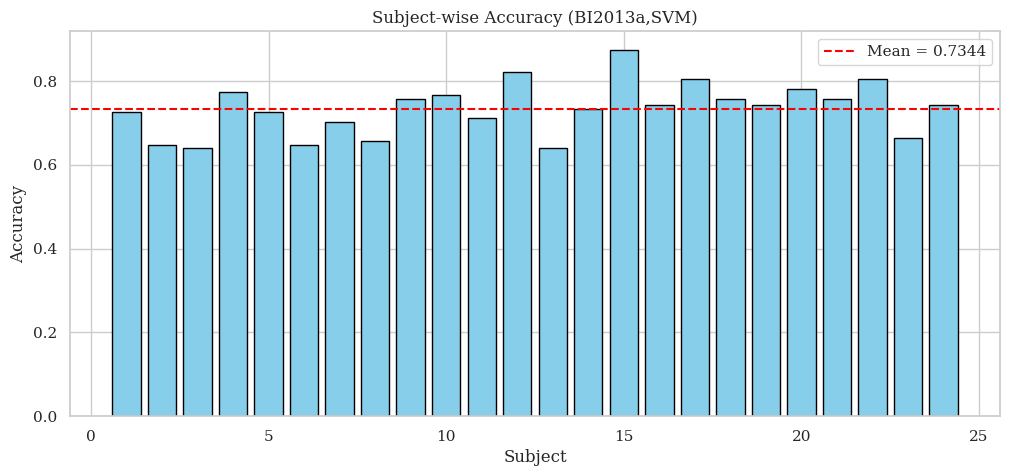

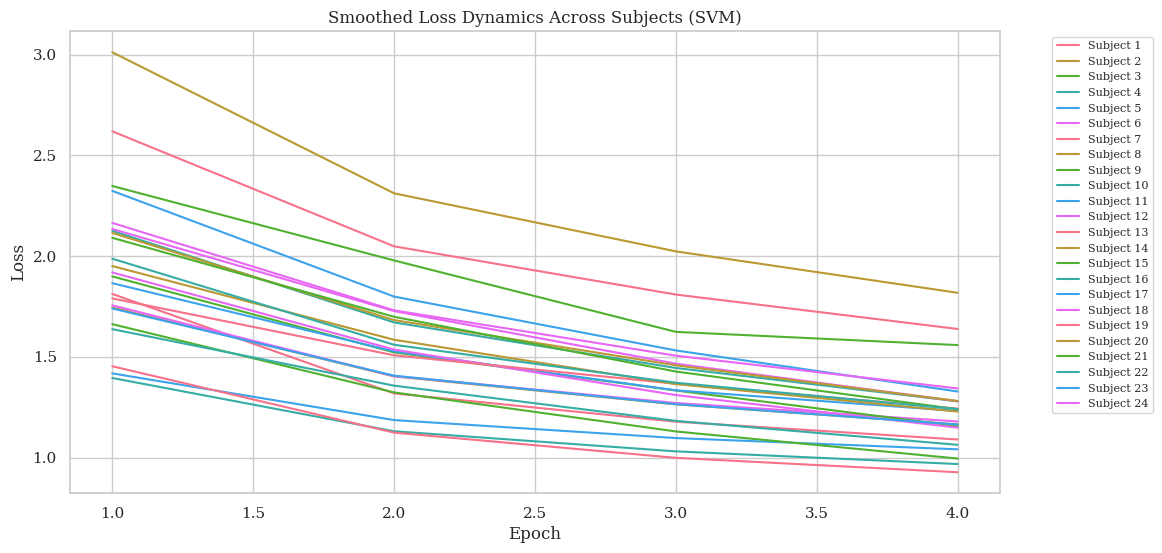

In [88]:
subjects = sorted(results.keys())
accuracies = torch.tensor([results[s]["accuracy"] for s in subjects])

mean_accuracy = torch.mean(accuracies)
std_accuracy = torch.std(accuracies)

print("Overall Results Across Subjects:")
for s in subjects:
    print(f"Subject {s}: Accuracy = {results[s]['accuracy']:.4f}")
print(f"\nMean Accuracy = {mean_accuracy:.4f}, Standard Deviation = {std_accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.bar(subjects, accuracies.tolist(), color="skyblue", edgecolor="black")
plt.axhline(mean_accuracy.item(), color="red", linestyle="--", label=f"Mean = {mean_accuracy:.4f}")
plt.xlabel("Subject")
plt.ylabel("Accuracy")
plt.title("Subject-wise Accuracy (BI2013a,SVM)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for s in subjects:
    losses = torch.tensor(results[s]["losses"])
    kernel = torch.ones(2) / 2
    smoothed_loss = torch.conv1d(
        losses.view(1, 1, -1),
        kernel.view(1, 1, -1),
        padding=0
    ).squeeze().tolist()

    plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, label=f"Subject {s}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Smoothed Loss Dynamics Across Subjects (SVM)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()
